In [1]:
!pip install PubChemPy

In [2]:
import pubchempy as pcp
import time
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
import lxml
import re
import io
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###SpectraBase Parser

In [ ]:
sb = open("D:\pubchem_annotations.xml\pubchem_annotations.xml", "r")

Compound(100)

In [ ]:
chems = []
record = '5'
i = 0
while True:
    i += 1
    while record.count('Thumbnail') == 0:
        with open(f"pubchem_{i}.xml", "a") as file:
            record = sb.readline()
            file.write(record)
    with open(f"pubchem_{i}.xml", "r") as file:
        soup = BeautifulSoup(file, "lxml")
    for k in soup.find_all('tocheading', string = True):
        if k.text.count('15N NMR'):
            chems.append(soup.find_all('inchikey', string = True)[0].text)
    record = sb.readline()
    os.remove(f"pubchem_{i}.xml")
    if record == '':
        break

In [ ]:
df = pd.DataFrame(chems)
df.to_csv('15N_inchikey_1.csv')

###SMILES from PubChem

In [ ]:
df_sb_pub = pd.read_csv('/content/drive/MyDrive/15N_inchikey_1.csv', names = ['Number', 'InChiKey'], header=0)

In [ ]:
df_sb_pub.insert(2, "SMILES", 'NaN')
df_sb_pub.insert(3, "N_count", 'NaN')
df_sb_pub

,Number,InChiKey,SMILES,N_count
0,0,NXWOOVVLGCEESD-UHFFFAOYSA-N,NaN,NaN
1,1,NXWOOVVLGCEESD-UHFFFAOYSA-N,NaN,NaN
2,2,LVILGAOSPDLNRM-UHFFFAOYSA-N,NaN,NaN
3,3,LVILGAOSPDLNRM-UHFFFAOYSA-N,NaN,NaN
4,4,LVILGAOSPDLNRM-UHFFFAOYSA-N,NaN,NaN
...,...,...,...,...
20989,20989,HSTKGKJDRKGGLK-UHFFFAOYSA-N,NaN,NaN
20990,20990,FOKDVFBDEKBAKV-UHFFFAOYSA-N,NaN,NaN
20991,20991,FOKDVFBDEKBAKV-UHFFFAOYSA-N,NaN,NaN
20992,20992,ISVXUNNXCXVRTK-UHFFFAOYSA-N,NaN,NaN


In [ ]:
i = 0
for inchikey in df_sb_pub.InChiKey:
    if i % 10 == 0:
      print(i)
    time.sleep(0.1)
    try:
        compound = pcp.get_compounds(inchikey, 'inchikey')[0]
        df_sb_pub.SMILES[i] = compound.isomeric_smiles
        df_sb_pub.N_count[i] = compound.isomeric_smiles.count('N')
        i += 1
    except IndexError:
        i += 1
        continue

In [ ]:
df_sb_pub

In [ ]:
df_sb_pub.to_csv('15N_InChiKey_SMILES.csv')

from google.colab import files
files.download('15N_InChiKey_SMILES.csv')

In [ ]:
df_smiles_inchekey = pd.read_csv('/content/15N_InChiKey_SMILES.csv')

In [ ]:
df_smiles_inchekey

,Unnamed: 0,Number,InChiKey,SMILES,N_count
0,0,0,NXWOOVVLGCEESD-UHFFFAOYSA-N,NaN,NaN
1,1,1,NXWOOVVLGCEESD-UHFFFAOYSA-N,NaN,NaN
2,2,2,LVILGAOSPDLNRM-UHFFFAOYSA-N,CC1=NC=NC=C1,2.0
3,3,3,LVILGAOSPDLNRM-UHFFFAOYSA-N,CC1=NC=NC=C1,2.0
4,4,4,LVILGAOSPDLNRM-UHFFFAOYSA-N,CC1=NC=NC=C1,2.0
...,...,...,...,...,...
20989,20989,20989,HSTKGKJDRKGGLK-UHFFFAOYSA-N,CN1CCCC1C2CCNCC2,2.0
20990,20990,20990,FOKDVFBDEKBAKV-UHFFFAOYSA-N,C1CN1C2=CC=C(C=C2)F,1.0
20991,20991,20991,FOKDVFBDEKBAKV-UHFFFAOYSA-N,C1CN1C2=CC=C(C=C2)F,1.0
20992,20992,20992,ISVXUNNXCXVRTK-UHFFFAOYSA-N,NaN,NaN


In [ ]:
df_smiles_inchekey.N_count.value_counts(dropna= False)

1.0     6253
NaN     4975
2.0     4646
3.0     2410
4.0     1451
5.0      706
6.0      251
8.0      104
7.0       64
9.0       48
10.0      38
11.0      22
12.0      18
20.0       4
18.0       4
Name: N_count, dtype: int64

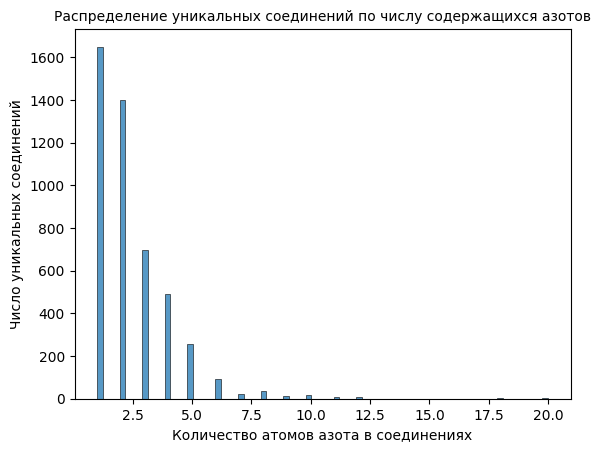

In [ ]:
sns.histplot(df_smiles_inchekey.drop_duplicates('SMILES').N_count)
plt.xlabel('Количество атомов азота в соединениях')
plt.ylabel('Число уникальных соединений')
plt.title('Распределение уникальных соединений по числу содержащихся азотов', size = 10)
plt.savefig('Unique_comp_N_count.png')

In [ ]:
df_for_target = df_smiles_inchekey.dropna().drop(['Unnamed: 0', 'Number'], axis=1)
df_for_target.to_excel('SMILES_target.xlsx')

In [ ]:
len(df_for_target.N_count)

16019

Разные способы получить фингерпринты

In [ ]:
#Morgan FP to vector (https://www.herongyang.com/Cheminformatics/Fingerprint-RDKit-Morgan-GetMorganFingerprint.html)
np.array(AllChem.GetMorganFingerprintAsBitVect(mol1, radius = 2 ,nBits=1024))

#RDKit FP to vector (https://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity)
np.array(AllChem.GetRDKitFPGenerator(numBitsPerFeature = 2, fpSize=1024).GetFingerprint(mol1))

#GetRDKitFPGenerator().GetFingerprint() to vector (https://www.herongyang.com/Cheminformatics/Fingerprint-RDKit-Daylight-GetRDKitFPGenerator.html)
gen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)
gen.GetFingerprint(mol1, fromAtoms=[2]).ToBitString()  #root of particular atom

#MolFormer (https://huggingface.co/ibm/MoLFormer-XL-both-10pct, https://github.com/IBM/molformer)
import torch
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)

smiles = ['CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O']
inputs = tokenizer(smiles, padding=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
outputs.pooler_output




In [ ]:
from rdkit.DataStructs import cDataStructs
mol = AllChem.MolFromSmiles('CCCC')
gen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)
fp = gen.GetFingerprint(ibuprofen, fromAtoms=[2])
a = fp.ToBitString()

fp = AllChem.RDKFingerprint(ibuprofen, fpSize=2048)
b = fp.ToBitString()

fp = gen.GetFingerprint(ibuprofen, fromAtoms=[4])
c = fp.ToBitString()

gen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=64,
  numBitsPerFeature=1)
fp = gen.GetCountFingerprint(mol)
display(cDataStructs.UIntSparseIntVect.GetNonzeroElements(fp))

fp = AllChem.RDKFingerprint(mol, fpSize=64, nBitsPerHash=1)
display(fp.ToBitString())

a == c

{21: 2, 28: 3, 43: 1}

'0000000000000000000001000000100000000000000100000000000000000000'

False

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 25.1 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
ms = [Chem.MolFromSmiles('CCOC'), Chem.MolFromSmiles('CCO'),
Chem.MolFromSmiles('COC')]
fpgen = AllChem.GetRDKitFPGenerator()
fps = [fpgen.GetFingerprint(x) for x in ms]
DataStructs.TanimotoSimilarity(fps[0],fps[1])

0.6

In [ ]:
DataStructs.TanimotoSimilarity(fps[0],fps[2])

0.4

In [ ]:
DataStructs.TanimotoSimilarity(fps[1],fps[2])

0.25

In [ ]:
np.sum(np.array(AllChem.GetMorganFingerprintAsBitVect(ibuprofen, 2 ,nBits=1024)) == np.array(AllChem.GetRDKitFPGenerator(numBitsPerFeature = 2, fpSize=1024).GetFingerprint(ibuprofen)))

795

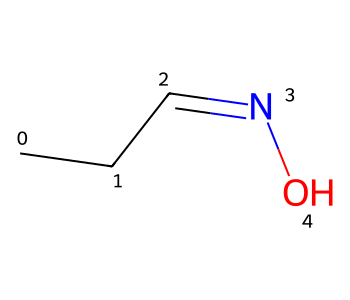

In [ ]:
from rdkit.Chem import Draw
opts = Draw.MolDrawOptions()
opts.addAtomIndices = True
ibuprofen = Chem.MolFromSmiles('CC/C=N\O')
Draw.MolToImage(ibuprofen,size=(350,300),options=opts)

In [ ]:
from rdkit.Chem import rdFingerprintGenerator
fpgen = AllChem.GetRDKitFPGenerator(numBitsPerFeature = 2, fpSize=1024)
np.array(fpgen.GetFingerprint(ibuprofen))

array([1, 1, 1, ..., 0, 1, 1])

In [ ]:
np.array(AllChem.GetMorganFingerprintAsBitVect(ibuprofen, 4 ,nBits=1024))

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
np.array(AllChem.GetMorganFingerprint(ibuprofen,2))

In [ ]:
opts = Draw.MolDrawOptions()
opts.addAtomIndices = True
ibuprofen = Chem.MolFromSmiles('COC1=CC=C(C=C1)C(=O)C[C@@H](C[N+](=O)[O-])C2=CC=CC=C2')
Draw.MolToImage(ibuprofen,size=(350,300),options=opts)


NameError: name 'Draw' is not defined

In [ ]:
rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=3, # <- max of 3 bonds in the subgraph
                                                    numBitsPerFeature=2) # <- only set one bit per subgraph (the default is 2)

ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitPaths()

fp = rdkgen.GetCountFingerprint(ibuprofen,fromAtoms=[4], additionalOutput=ao)
ao.GetBitPaths()

{161: ((4, 5, 6), (4, 5, 14), (4, 14, 8), (14, 8, 7)),
 294: ((4, 5), (4, 14), (14, 8)),
 330: ((4, 5), (4, 14), (14, 8)),
 744: ((3, 14), (3, 4)),
 826: ((3, 2),),
 842: ((4,), (14,)),
 854: ((3, 14, 4),),
 923: ((3, 2, 1), (3, 2, 0)),
 930: ((3,),),
 977: ((3, 14, 8), (3, 4, 5)),
 1026: ((4,), (14,)),
 1060: ((3,),),
 1251: ((3, 14, 2), (3, 4, 2)),
 1344: ((3, 14, 2), (3, 4, 2)),
 1384: ((3, 2),),
 1545: ((3, 14, 4),),
 1784: ((4, 5, 6), (4, 5, 14), (4, 14, 8), (14, 8, 7)),
 1816: ((3, 14, 8), (3, 4, 5)),
 1909: ((3, 14), (3, 4)),
 1915: ((3, 2, 1), (3, 2, 0))}

In [ ]:
fp = rdkgen.GetCountFingerprint(ibuprofen,fromAtoms=[4], additionalOutput=ao)

In [ ]:
ao.GetAtomToBits()

In [ ]:
fp2 = rdkgen.GetSparseCountFingerprint(ibuprofen,fromAtoms=[2], additionalOutput=ao)
ao.GetBitPaths()[161]

KeyError: 161

In [ ]:
m1 = Chem.MolFromSmiles('c1ccccn1')
m2 = Chem.MolFromSmiles('c1ccco1')
fp1 = AllChem.GetMorganFingerprint(m1,2)
fp2 = AllChem.GetMorganFingerprint(m2,2)
ffp1 = AllChem.GetMorganFingerprint(m1,2,useFeatures=True)
ffp2 = AllChem.GetMorganFingerprint(m2,2,useFeatures=True)

In [ ]:
list(ffp1)

###MolFormer


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)

smiles = ['CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O']
inputs = tokenizer(smiles, padding=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
outputs.pooler_output


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tensor([[ 3.2324e-03,  3.7600e-01,  3.7311e-01,  5.9598e-01, -6.0751e-01,
         -5.6225e-01, -6.4048e-01,  2.4823e-01,  4.4927e-02, -2.8585e-01,
         -2.1138e-01,  5.7907e-01,  2.2549e-01,  2.5613e-01,  9.2231e-01,
          7.0048e-01,  2.9994e-01, -2.4676e-01, -2.2465e-01, -2.6830e-01,
         -3.7476e-01,  7.9078e-01,  8.6083e-01, -1.1147e-01, -5.8671e-01,
         -1.7157e-01, -1.0699e+00, -4.9544e-01, -2.0514e-01,  2.2237e-01,
          6.5324e-02, -2.6718e-01, -5.8102e-01,  7.0936e-01,  4.8985e-01,
         -4.2775e-01, -8.7517e-01, -2.0364e-01, -1.2036e+00, -1.2411e-01,
          5.1391e-01,  9.6892e-01, -6.2088e-01, -4.0028e-01, -3.9078e-02,
         -7.3236e-01, -1.1922e-01,  2.2095e-01,  4.1448e-01, -1.7104e-01,
          7.1494e-01,  5.1389e-03,  4.3668e-02,  9.1235e-01,  9.8268e-02,
         -2.6758e-01, -2.3470e-01, -3.7887e-01, -5.3113e-01, -4.9856e-01,
          5.1804e-03, -1.1991e-01, -4.6070e-01, -1.2190e-01,  1.2583e-01,
          2.7858e-01,  5.0454e-01, -2.

In [ ]:
outputs.pooler_output.size()

torch.Size([1, 768])

###FP-BERT

In [ ]:
!pip install git+https://github.com/samoturk/mol2vec

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-uexda072
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /tmp/pip-req-build-uexda072
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.4 MB/s eta 0:00:00
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14016 sha256=913cbc25bc90c2050e9d8bee66c95591246e2b02da69cea7564252554a4218d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_q75jndb/wheels/b9/bd/e0/b6dd7c5e346247e8d6944e08ca1c262a908231747f4efa539d
Successfully built mol2vec


In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('my_tokenizers2','wb').write(src)

Saving my_tokenizers2.py to my_tokenizers2.py


6084

In [ ]:
from my_tokenizers2 import SmilesTokenizer
import numpy as np
import torch
tokenizer = SmilesTokenizer(vocab_file ='mol2vec_vocabs.txt')

AttributeError: 'SmilesTokenizer' object has no attribute 'max_len'

In [ ]:
from transformers import ElectraModel, ElectraConfig,ElectraForPreTraining,ElectraForMaskedLM
emb_dim = 256
output_dir="/content/fingerprints_smile_output256"
electra_model = ElectraForMaskedLM.from_pretrained(output_dir)

In [ ]:
from tqdm import tqdm
from rdkit import Chem
from mol2vec.features import mol2alt_sentence

#smiles_seqs_emb = {}
#smiles_aug_dict = {}

embX = []
MAX_SMI_LEN = 256

for item in tqdm(newSm):

    smiles = item
    aas = Chem.MolFromSmiles(item)
    sentence = mol2alt_sentence(aas, 1)
    sentence = ' '.join(map(str, sentence))
    input_ids = tokenizer(sentence, return_tensors="pt")["input_ids"]
    if len(input_ids[0]) > MAX_SMI_LEN:
        print(smiles)
        input_ids = input_ids[:, :MAX_SMI_LEN]
        input_ids[:,255:256] = 3

    outputs = electra_model(input_ids, labels=input_ids)
    embX.append(outputs[2][0].detach().numpy()[0][1:-1])

###BaseLine


#####Preprocessing

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Neural net in science/Project/SMILES_target_copy_1.xlsx', decimal=',')

In [ ]:
df_1N = df[df['Solvent'].notna()].query('N_count == 1')

In [ ]:
df_1N = df_1N.dropna(axis = 1)

In [ ]:
df_1N

,Unnamed: 0,InChiKey,SMILES,N_count,Solvent,Target1
6,12,MCRMUCXATQAAMN-HNNXBMFYSA-N,C1=CC=C(C=C1)COC(=O)N[C@@H](CC2=CC=C(C=C2)O)C(...,1.0,DMSO,-292.6
26,36,JRKMVLFFQOHRHM-VHSXEESVSA-N,C[C@H]1CC[C@H]2CCCCN2C1,1.0,CDCl3,-53.2
28,38,OISVCGZHLKNMSJ-UHFFFAOYSA-O,CC1=[NH+]C(=CC=C1)C,1.0,TFA(C=14.5MOL%),-177
29,39,OISVCGZHLKNMSJ-UHFFFAOYSA-O,CC1=[NH+]C(=CC=C1)C,1.0,Neat liquid,-171.7
30,40,OISVCGZHLKNMSJ-UHFFFAOYSA-O,CC1=[NH+]C(=CC=C1)C,1.0,CHCl,-64.7
...,...,...,...,...,...,...
1281,1734,NXBBFAKHXAMPOM-SNAWJCMRSA-N,C/C=C/N(C)C,1.0,Neat liquid,-350.8
1288,1743,ZMANZCXQSJIPKH-UHFFFAOYSA-N,CCN(CC)CC,1.0,CH3OH,-332
1291,1746,ZMANZCXQSJIPKH-UHFFFAOYSA-O,[H+].CCN(CC)CC,1.0,Neat liquid,-350.8
1294,1749,ZLWIMPFRPFWOGK-UHFFFAOYSA-N,CN1C=C2C=CC=CC2=C1,1.0,DIETHYLETHER,-218


In [ ]:
df_1N.SMILES.unique().shape

(140,)

In [ ]:
df_1N.Solvent.value_counts()

Solvent
CDCl3               28
Neat liquid         16
DMSO                14
CDCl3               14
CH3OH               14
C6D6                12
DMSO-D6             11
DMSO                 5
H2O                  5
Neat                 5
DMSO-D6              4
DMSO;CR(ACAC)3       4
D2O                  4
CDCl3;CR(ACAC)3      3
C6D6                 3
CHCl3                3
solid-state          3
H2O                  3
CHCl3                3
C6D6;CR(ACAC)3       3
CYClOHEXANONE        2
HMPA                 2
CF3COOD              2
CH3NO2               2
ETHYLENGLYCOL        2
DIOXANE              2
DIOXAN               2
CHCl3;CR(ACAC)3      2
TFE                  2
Hexane               2
H2O:D2O              2
D2O                  1
CCl4                 1
(CH3)2SO4            1
THF-D8               1
D2O:H2O              1
CH3OH (PH=12)        1
HCl                  1
ACETONITRILE-D3      1
TFA(C=14.5MOL%)      1
Cyclohexane          1
CH3OH (PH=1)         1
DMF                  1
FSO

In [ ]:
df_1N_multisolvent = df_1N.loc[df_1N.duplicated(subset='SMILES', keep=False)]

In [ ]:
df_1N_multisolvent.SMILES.value_counts()

SMILES
C(=O)N                                           12
CNC=O                                            11
CC1=NC(=CC=C1)C                                   6
C1=CSC=N1                                         5
C1CCNC(=O)C1                                      4
CC1=[NH+]C(=CC=C1)C                               4
CC#N                                              3
C1CCC2C(C1)CCCN2                                  3
CC(C)(C)C(=O)/C=C/N(C)C                           2
CNCC(=O)OC.Cl                                     2
CC1=C(C(C(=C(N1)C)C(=O)OC)C2=CC=CC=C2)C(=O)OC     2
CC(C(=O)O)[NH3+]                                  2
CC(C)C(=O)/C=C\N                                  2
CC(C)C(=O)/C=C\NC(C)(C)C                          2
[NH4+].[Cl-]                                      2
CCOC(=O)/C=C(/C)\NCC1=CC=CC=C1                    2
CN(C)S(=O)(=O)C                                   2
CC1=C(C(C(=C(N1)C)C(=O)C)C(=O)O)C(=O)C            2
CC(C)(C)C(=O)NC                                   2
C1=CC

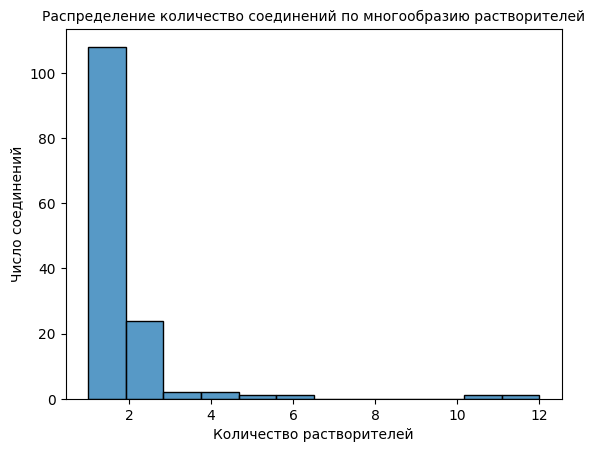

In [ ]:
sns.histplot(df_1N.SMILES.value_counts(), bins = 12)
plt.xlabel('Количество растворителей')
plt.ylabel('Число соединений')
plt.title('Распределение количество соединений по многообразию растворителей', size = 10)
plt.savefig('Solv.png')

In [ ]:
df_1N_multisolvent[df.SMILES == 'CNC=O']

<ipython-input-32-97d08547cdc4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_1N_multisolvent[df.SMILES == 'CNC=O']


,Unnamed: 0,InChiKey,SMILES,N_count,Solvent,Target1
892,1242,ATHHXGZTWNVVOU-UHFFFAOYSA-N,CNC=O,1.0,Neat,-271
893,1243,ATHHXGZTWNVVOU-UHFFFAOYSA-N,CNC=O,1.0,DMSO-D6,-271.4
894,1248,ATHHXGZTWNVVOU-UHFFFAOYSA-N,CNC=O,1.0,DIOXAN,-271.3
895,1249,ATHHXGZTWNVVOU-UHFFFAOYSA-N,CNC=O,1.0,CYClOHEXANONE,-271.1
896,1250,ATHHXGZTWNVVOU-UHFFFAOYSA-N,CNC=O,1.0,HMPA,-270.3
897,1251,ATHHXGZTWNVVOU-UHFFFAOYSA-N,CNC=O,1.0,DMSO,-268.8
898,1254,ATHHXGZTWNVVOU-UHFFFAOYSA-N,CNC=O,1.0,CH3NO2,-270.2
899,1255,ATHHXGZTWNVVOU-UHFFFAOYSA-N,CNC=O,1.0,CH3OH,-267.2
900,1256,ATHHXGZTWNVVOU-UHFFFAOYSA-N,CNC=O,1.0,ETHYLENGLYCOL,-264.8
901,1257,ATHHXGZTWNVVOU-UHFFFAOYSA-N,CNC=O,1.0,H2O,-262.9


In [ ]:
df_1N_multisolvent.Solvent.value_counts()

Solvent
CDCl3              8
DMSO               7
Neat liquid        6
C6D6               6
H2O                5
DMSO-D6            5
CDCl3              4
Neat               4
DMSO-D6            3
H2O                3
CHCl3              2
DIOXAN             2
CF3COOD            2
ETHYLENGLYCOL      2
CYClOHEXANONE      2
CH3OH              2
D2O                2
CH3NO2             2
HMPA               2
CHCl3;CR(ACAC)3    1
TFA(C=14.5MOL%)    1
CH3OH (PH=12)      1
CDCl3;CR(ACAC)3    1
D2O:H2O            1
THF-D8             1
HCl                1
ACETONITRILE-D3    1
H2O:D2O            1
CCl4               1
C6H12              1
CH3OH (PH=1)       1
FSO3H:SBF5:SO2     1
H2SO4              1
Cyclohexane        1
TFA                1
ACETONE-D6         1
CCl4               1
DMSO               1
Hexane             1
C6H6               1
C6D6               1
DMSO;CR(ACAC)3     1
TFE                1
TFE                1
CHCl               1
CHCl3              1
Name: count, dtype: int64

In [ ]:
df_bl = df_1N.drop_duplicates('SMILES')

In [ ]:
conditions = [
    (df_bl['Target1'] <= -318),
    (df_bl['Target1'] > -318) & (df_bl['Target1'] <= -266),
    (df_bl['Target1'] > -266) & (df_bl['Target1'] <= -175),
    (df_bl['Target1'] > -175)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4']

# create a new column and use np.select to assign values to it using our lists as arguments
df_bl['Group'] = np.select(conditions, values)

<ipython-input-16-beecc59487e7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl['Group'] = np.select(conditions, values)


In [ ]:
df_bl

,Unnamed: 0,InChiKey,SMILES,N_count,Solvent,Target1
6,12,MCRMUCXATQAAMN-HNNXBMFYSA-N,C1=CC=C(C=C1)COC(=O)N[C@@H](CC2=CC=C(C=C2)O)C(...,1.0,DMSO,-292.6
26,36,JRKMVLFFQOHRHM-VHSXEESVSA-N,C[C@H]1CC[C@H]2CCCCN2C1,1.0,CDCl3,-53.2
28,38,OISVCGZHLKNMSJ-UHFFFAOYSA-O,CC1=[NH+]C(=CC=C1)C,1.0,TFA(C=14.5MOL%),-177
33,43,OISVCGZHLKNMSJ-UHFFFAOYSA-N,CC1=NC(=CC=C1)C,1.0,CHCl3,-69.1
74,92,SMUQFGGVLNAIOZ-UHFFFAOYSA-N,CC1=NC2=CC=CC=C2C=C1,1.0,(CH3)2SO4,-73.1
...,...,...,...,...,...,...
1281,1734,NXBBFAKHXAMPOM-SNAWJCMRSA-N,C/C=C/N(C)C,1.0,Neat liquid,-350.8
1288,1743,ZMANZCXQSJIPKH-UHFFFAOYSA-N,CCN(CC)CC,1.0,CH3OH,-332
1291,1746,ZMANZCXQSJIPKH-UHFFFAOYSA-O,[H+].CCN(CC)CC,1.0,Neat liquid,-350.8
1294,1749,ZLWIMPFRPFWOGK-UHFFFAOYSA-N,CN1C=C2C=CC=CC2=C1,1.0,DIETHYLETHER,-218


In [ ]:
y = df_bl.Target1.astype('float').to_numpy()
y

array([-292.6  ,  -53.2  , -177.   ,  -69.1  ,  -73.1  , -249.2  ,
       -136.   , -325.9  , -335.2  , -336.6  , -318.9  , -317.5  ,
       -240.8  , -279.7  , -252.8  , -255.1  ,  -80.   , -349.4  ,
       -345.625,  -61.5  , -261.2  ,  -67.2  , -338.   , -348.2  ,
       -123.2  ,  -64.1  , -352.   , -343.8  , -246.2  , -339.9  ,
       -326.4  ,  -49.7  , -346.2  , -265.8  ,  -63.6  , -134.7  ,
       -335.4  , -262.1  , -271.4  , -289.9  , -271.3  , -285.   ,
       -169.1  , -307.6  , -295.9  , -308.9  , -121.8  , -256.5  ,
        -79.2  , -250.3  , -248.7  , -166.1  ,  -66.   , -222.   ,
       -277.5  , -305.1  , -262.1  , -317.7  , -279.1  , -278.2  ,
       -326.6  , -206.   , -256.8  , -347.9  , -247.3  , -258.1  ,
        -70.2  ,  -13.1  , -254.9  , -143.6  , -282.3  , -239.2  ,
       -251.2  , -147.6  , -141.8  ,  -66.3  ,  -32.9  , -317.   ,
       -305.1  , -325.1  , -328.6  , -317.   , -194.3  , -324.2  ,
       -319.1  , -286.   , -102.5  , -199.9  , -241.3  , -249.

In [ ]:
y.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

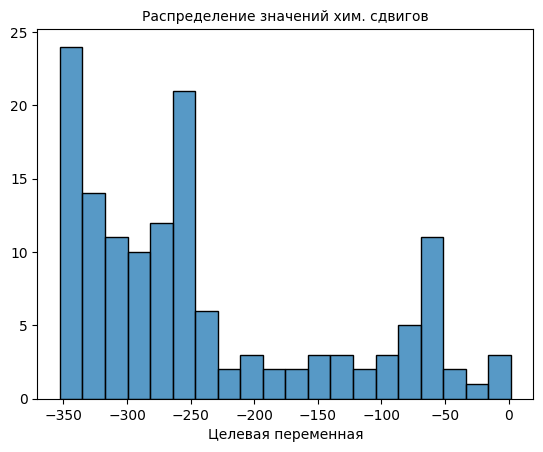

In [ ]:
sns.histplot(y, bins= 20)
plt.xlabel('Целевая переменная')
plt.ylabel('')
plt.title('Распределение значений хим. сдвигов', size = 10)
plt.savefig('Solv.png')

<Axes: >

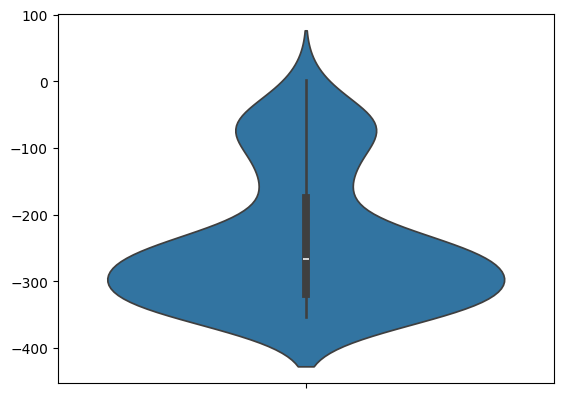

In [ ]:
sns.violinplot(y)

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)

smiles = df_bl.SMILES.to_list()
inputs = tokenizer(smiles, padding=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
outputs.pooler_output

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tensor([[ 0.4368,  0.2937,  0.2944,  ...,  0.3945, -0.2834, -0.3941],
        [ 0.0674,  0.1458, -0.3140,  ..., -0.2005, -0.2513, -0.3298],
        [ 0.8753,  0.0054,  0.9971,  ...,  1.1829, -0.6313, -0.3185],
        ...,
        [ 0.5736, -0.0473,  0.7308,  ...,  0.5041, -0.2776,  0.4817],
        [ 0.4938,  0.3575,  0.4180,  ...,  1.0942, -0.6459, -0.7786],
        [ 0.3645,  0.0166, -0.3258,  ...,  0.3311, -0.0980,  0.1576]])

In [ ]:
x = outputs.pooler_output.numpy()
x.shape

(140, 768)

In [ ]:
df_bl['Group'].value_counts()

Group
1    36
4    35
3    35
2    34
Name: count, dtype: int64

#####RandomForest

In [ ]:
import random

random.seed(42)
np.random.seed(42)


from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify= df_bl['Group'], random_state=42)

<Axes: ylabel='Count'>

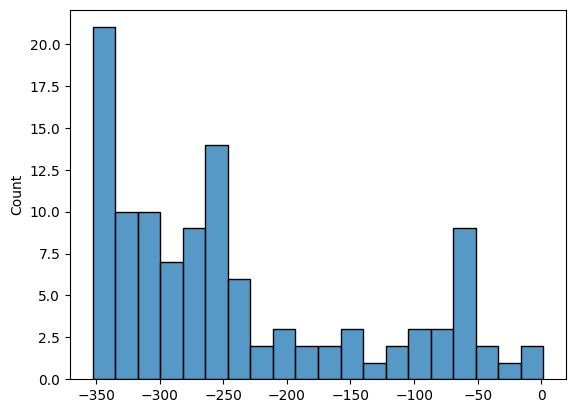

In [ ]:
sns.histplot(y_train, bins = 20)

<Axes: ylabel='Count'>

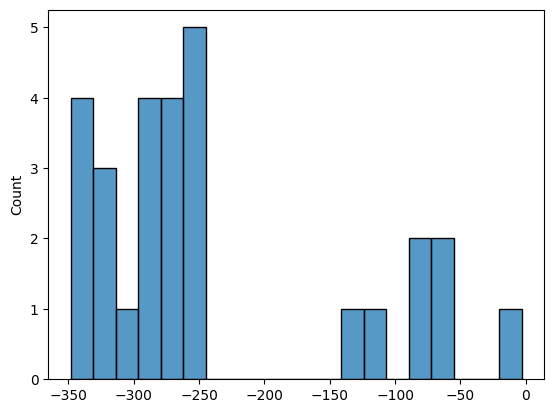

In [ ]:
sns.histplot(y_test, bins = 20)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Your code here

rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [ ]:
df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df

,Actual,Predicted
0,-256.8,-213.62525
1,-252.8,-200.76800
2,-262.1,-189.32800
3,-279.7,-242.24800
4,-348.2,-300.38450
5,-285.0,-221.38300
6,-326.6,-213.26700
7,-123.2,-188.67400
8,-258.1,-150.46000
9,-331.3,-300.99275


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f"Mean absolute error RF: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"Mean squared error RF: {mean_squared_error(y_test, y_pred):.3f}")
print(f"Root mean squared error RF: {mean_squared_error(y_test, y_pred, squared=False):.3f}")

Mean absolute error RF: 84.945
Mean squared error RF: 10134.166
Root mean squared error RF: 100.669


<Axes: ylabel='Count'>

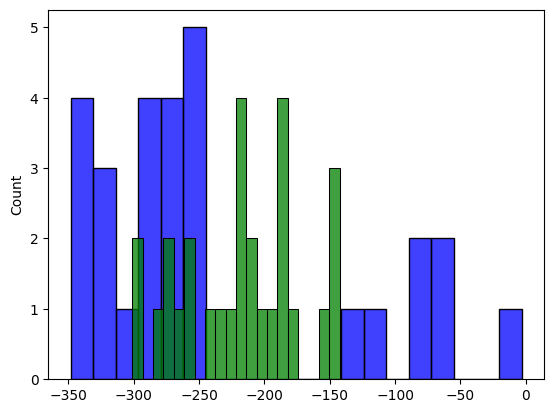

In [ ]:
sns.histplot(y_test, color = 'blue', bins = 20)
sns.histplot(y_pred, color = 'green', bins = 20)

####SVR

In [ ]:
from sklearn import svm
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
  svc = svm.SVR(kernel= kernel)
  svc.fit(x_train, y_train)
  y_pred = svc.predict(x_test)
  print(f'MAE for {kernel} = {mean_absolute_error(y_test, y_pred):.3f}')

MAE for linear = 66.938
MAE for poly = 69.693
MAE for rbf = 70.002
MAE for sigmoid = 70.480


In [ ]:
from sklearn.model_selection import GridSearchCV


parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C': np.linspace(1, 10, 10), 'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
svr = svm.SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(x_train, y_train)
clf.best_params_

{'C': 1.0, 'degree': 1, 'kernel': 'linear'}

In [ ]:
y_pred = clf.predict(x_test)
print(f'MAE for best SVR = {mean_absolute_error(y_test, y_pred):.3f}')

MAE for best SVR = 66.938


In [ ]:
df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df

,Actual,Predicted
0,-256.8,-208.764310
1,-252.8,-218.386272
2,-262.1,-196.669489
3,-279.7,-287.118800
4,-348.2,-325.373015
5,-285.0,-211.079822
6,-326.6,-245.655414
7,-123.2,-188.068715
8,-258.1,-172.250630
9,-331.3,-314.190567


<Axes: ylabel='Count'>

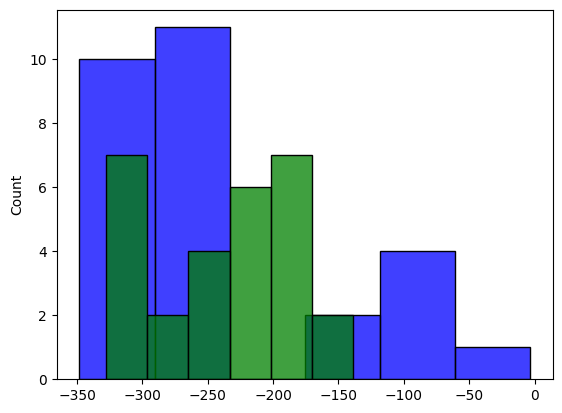

In [ ]:
sns.histplot(y_test, color = 'blue')
sns.histplot(y_pred, color = 'green')

######KNRegressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)

print(f"Mean absolute error KNeighborsRegressor: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"Mean squared error KNeighborsRegressor: {mean_squared_error(y_test, y_pred):.3f}")
print(f"Root mean squared error KNeighborsRegressor: {mean_squared_error(y_test, y_pred, squared=False):.3f}")

df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df

Mean absolute error KNeighborsRegressor: 72.636
Mean squared error KNeighborsRegressor: 8945.570
Root mean squared error KNeighborsRegressor: 94.581


,Actual,Predicted
0,-256.8,-119.133333
1,-252.8,-205.733333
2,-262.1,-154.233333
3,-279.7,-281.500000
4,-348.2,-343.000000
5,-285.0,-264.266667
6,-326.6,-182.000000
7,-123.2,-121.533333
8,-258.1,-137.333333
9,-331.3,-343.875000


In [ ]:
parameters = {'weights':['uniform', 'distance'], 'n_neighbors': np.linspace(1, 10, 10, dtype= 'int'),'algorithm' : ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': np.linspace(5, 50, 10, dtype= 'int')}
neigh = KNeighborsRegressor(n_neighbors=3)
clf = GridSearchCV(neigh, parameters)
clf.fit(x_train, y_train)
clf.best_params_

{'algorithm': 'brute', 'leaf_size': 5, 'n_neighbors': 9, 'weights': 'distance'}

In [ ]:
y_pred = clf.predict(x_test)
print(f'MAE for best KNN = {mean_absolute_error(y_test, y_pred):.3f}')

MAE for best KNN = 80.142


In [ ]:
neigh = KNeighborsRegressor(algorithm = 'ball_tree', leaf_size = 5, n_neighbors = 8, weights = 'uniform')
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)

print(f"Mean absolute error KNeighborsRegressor: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"Mean squared error KNeighborsRegressor: {mean_squared_error(y_test, y_pred):.3f}")
print(f"Root mean squared error KNeighborsRegressor: {mean_squared_error(y_test, y_pred, squared=False):.3f}")

df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df

Mean absolute error KNeighborsRegressor: 80.073
Mean squared error KNeighborsRegressor: 8450.388
Root mean squared error KNeighborsRegressor: 91.926


,Actual,Predicted
0,-256.8,-184.512500
1,-252.8,-194.325000
2,-262.1,-192.962500
3,-279.7,-277.912500
4,-348.2,-315.837500
5,-285.0,-165.487500
6,-326.6,-240.075000
7,-123.2,-215.287500
8,-258.1,-154.937500
9,-331.3,-293.653125


<Axes: ylabel='Count'>

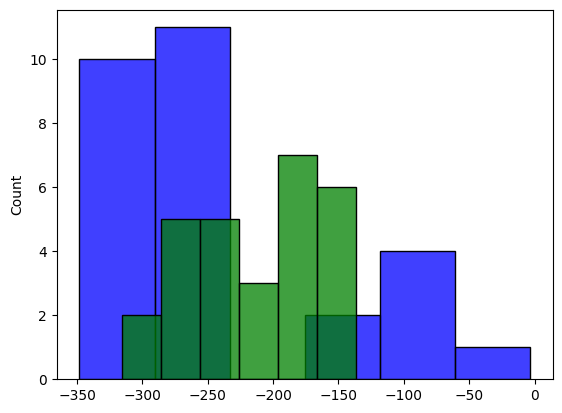

In [ ]:
sns.histplot(y_test, color = 'blue')
sns.histplot(y_pred, color = 'green')

#####Log y

In [ ]:
import random

random.seed(42)
np.random.seed(42)


from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify= df_bl['Group'], random_state=42)

In [ ]:
y_train = np.log(y_train + 1000)

<Axes: ylabel='Count'>

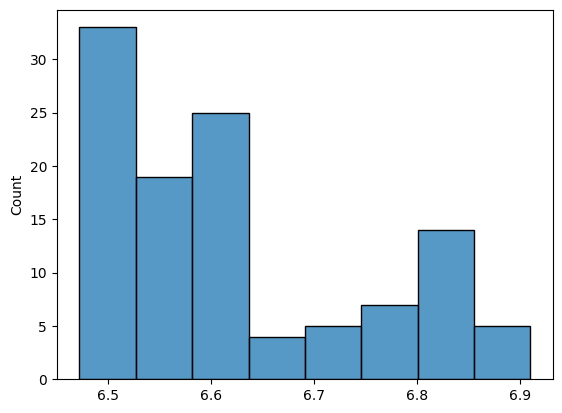

In [ ]:
sns.histplot(y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Your code here

rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

df = pd.DataFrame({"Actual": y_test, "Predicted": np.exp(y_pred)-1000})
df

,Actual,Predicted
0,-256.8,-220.472440
1,-252.8,-213.886725
2,-262.1,-174.781572
3,-279.7,-253.369383
4,-348.2,-319.131192
5,-285.0,-221.577707
6,-326.6,-233.104436
7,-123.2,-180.932645
8,-258.1,-173.907426
9,-331.3,-301.071906


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_tr = np.exp(y_pred)-1000
print(f"Mean absolute error RF: {mean_absolute_error(y_test, y_pred_tr):.3f}")
print(f"Mean squared error RF: {mean_squared_error(y_test, y_pred_tr):.3f}")
print(f"Root mean squared error RF: {mean_squared_error(y_test, y_pred_tr, squared=False):.3f}")

Mean absolute error RF: 76.839
Mean squared error RF: 8668.717
Root mean squared error RF: 93.106


<Axes: ylabel='Count'>

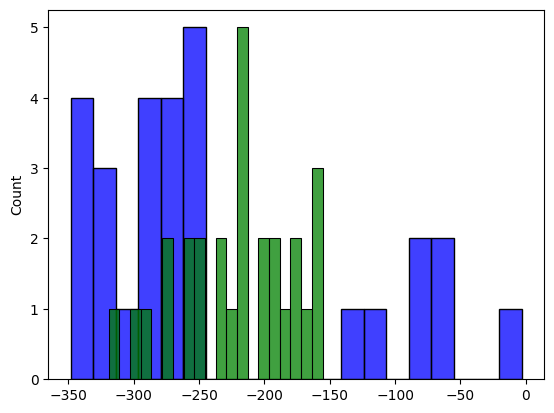

In [ ]:
sns.histplot(y_test, color = 'blue', bins = 20)
sns.histplot(y_pred_tr, color = 'green', bins = 20)

In [ ]:
from sklearn import svm
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
  svc = svm.SVR(kernel= kernel)
  svc.fit(x_train, y_train)

  y_pred = svc.predict(x_test)
  y_pred_tr = np.exp(y_pred)-1000

  print(f'MAE for {kernel} = {mean_absolute_error(y_test, y_pred_tr):.3f}')

MAE for linear = 79.806
MAE for poly = 84.368
MAE for rbf = 81.029
MAE for sigmoid = 67.804


In [ ]:
from sklearn.model_selection import GridSearchCV


parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C': np.linspace(1, 10, 10), 'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
svr = svm.SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(x_train, y_train)
clf.best_params_

{'C': 2.0, 'degree': 1, 'kernel': 'sigmoid'}

In [ ]:
y_pred = clf.predict(x_test)
y_pred_tr = np.exp(y_pred)-1000
print(f'MAE for best SVR = {mean_absolute_error(y_test, y_pred_tr):.3f}')

MAE for best SVR = 64.237


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)
y_pred_tr = np.exp(y_pred)-1000

print(f"Mean absolute error KNeighborsRegressor: {mean_absolute_error(y_test, y_pred_tr):.3f}")
print(f"Mean squared error KNeighborsRegressor: {mean_squared_error(y_test, y_pred_tr):.3f}")
print(f"Root mean squared error KNeighborsRegressor: {mean_squared_error(y_test, y_pred_tr, squared=False):.3f}")

df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_tr})
df

Mean absolute error KNeighborsRegressor: 71.776
Mean squared error KNeighborsRegressor: 8779.354
Root mean squared error KNeighborsRegressor: 93.698


,Actual,Predicted
0,-256.8,-122.024633
1,-252.8,-207.869269
2,-262.1,-156.898812
3,-279.7,-281.728405
4,-348.2,-343.022516
5,-285.0,-264.425599
6,-326.6,-185.937293
7,-123.2,-123.387978
8,-258.1,-141.052465
9,-331.3,-343.896922


In [ ]:
parameters = {'weights':['uniform', 'distance'], 'n_neighbors': np.linspace(1, 10, 10, dtype= 'int'),'algorithm' : ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': np.linspace(5, 50, 10, dtype= 'int')}
neigh = KNeighborsRegressor(n_neighbors=3)
clf = GridSearchCV(neigh, parameters)
clf.fit(x_train, y_train)
print(clf.best_params_)


y_pred = clf.predict(x_test)
y_pred_tr = np.exp(y_pred)-1000
print(f'MAE for best KNN = {mean_absolute_error(y_test, y_pred_tr):.3f}')

{'algorithm': 'brute', 'leaf_size': 5, 'n_neighbors': 9, 'weights': 'distance'}
MAE for best KNN = 78.844


####Classification and regression

In [ ]:
df_bl['Group'] = np.where(df_bl['Target1'] > -200, 1, 2)

<ipython-input-35-971c04224e94>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl['Group'] = np.where(df_bl['Target1'] > -200, 1, 2)


In [ ]:
df_bl

,Unnamed: 0,InChiKey,SMILES,N_count,Solvent,Target1,Group
6,12,MCRMUCXATQAAMN-HNNXBMFYSA-N,C1=CC=C(C=C1)COC(=O)N[C@@H](CC2=CC=C(C=C2)O)C(...,1.0,DMSO,-292.6,2
26,36,JRKMVLFFQOHRHM-VHSXEESVSA-N,C[C@H]1CC[C@H]2CCCCN2C1,1.0,CDCl3,-53.2,1
28,38,OISVCGZHLKNMSJ-UHFFFAOYSA-O,CC1=[NH+]C(=CC=C1)C,1.0,TFA(C=14.5MOL%),-177,1
33,43,OISVCGZHLKNMSJ-UHFFFAOYSA-N,CC1=NC(=CC=C1)C,1.0,CHCl3,-69.1,1
74,92,SMUQFGGVLNAIOZ-UHFFFAOYSA-N,CC1=NC2=CC=CC=C2C=C1,1.0,(CH3)2SO4,-73.1,1
...,...,...,...,...,...,...,...
1281,1734,NXBBFAKHXAMPOM-SNAWJCMRSA-N,C/C=C/N(C)C,1.0,Neat liquid,-350.8,2
1288,1743,ZMANZCXQSJIPKH-UHFFFAOYSA-N,CCN(CC)CC,1.0,CH3OH,-332,2
1291,1746,ZMANZCXQSJIPKH-UHFFFAOYSA-O,[H+].CCN(CC)CC,1.0,Neat liquid,-350.8,2
1294,1749,ZLWIMPFRPFWOGK-UHFFFAOYSA-N,CN1C=C2C=CC=CC2=C1,1.0,DIETHYLETHER,-218,2


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Your code here

x_train, x_test, y_train, y_test = train_test_split(x, df_bl['Group'], test_size=0.2, stratify= df_bl['Group'], random_state=42)

rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
# Your code here
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           1       0.38      0.60      0.46         5
           2       0.90      0.78      0.84        23

    accuracy                           0.75        28
   macro avg       0.64      0.69      0.65        28
weighted avg       0.81      0.75      0.77        28



In [ ]:
y_pred,y_test

(array([2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
        2, 2, 2, 1, 2, 2]),
 1119    2
 751     2
 172     2
 1250    2
 176     1
 950     2
 482     1
 101     2
 812     2
 735     1
 1197    2
 78      2
 697     1
 115     2
 119     2
 638     2
 599     2
 652     1
 646     2
 207     2
 117     2
 232     2
 979     2
 1212    2
 869     1
 1205    1
 293     1
 546     2
 Name: Group, dtype: int64)